In [1]:
!pip install nose

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 2.7 MB/s eta 0:00:00


### Main code



In [2]:
import numpy as np
from scipy.stats import norm
from scipy.signal import fftconvolve
from scipy.special import softmax
# from tqdm import tqdm


EPS = 1e-16


def calculate_log_probability(X, F, B, s):
    """
    Calculates log p(X_k|d_k,F,B,s) for all images X_k in X and
    all possible displacements d_k.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (h, w)
        Estimate of villain's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.

    Returns
    -------
    ll : array, shape(H-h+1, W-w+1, K)
        ll[dh, dw, k] - log-likelihood of observing image X_k given
        that the villain's face F is located at displacement (dh, dw)
    """
    H, W, _ = X.shape
    h, w = F.shape
    part_XB = (X - B[..., None]) ** 2
    part_F = (fftconvolve(X * X, np.ones((h, w, 1)), mode="valid") -
              2 * fftconvolve(X, F[::-1, ::-1, None], mode="valid") +
              (F * F).sum())
    part_B = (np.sum(part_XB, axis=(0, 1)) -
              fftconvolve(part_XB, np.ones((h, w, 1)), mode="valid"))
    ll = - H * W * (np.log((2 * np.pi) ** 0.5) + np.log(s + EPS)) - (part_F + part_B) / (2 * (s ** 2) + EPS)

    return ll


def calculate_lower_bound(X, F, B, s, A, q, use_MAP=False):
    """
    Calculates the lower bound L(q,F,B,s,A) for the marginal log likelihood.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (h, w)
        Estimate of villain's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1)
        Estimate of prior on displacement of face in any image.
    q : array
        If use_MAP = False: shape (H-h+1, W-w+1, K)
            q[dh,dw,k] - estimate of posterior of displacement (dh,dw)
            of villain's face given image Xk
        If use_MAP = True: shape (2, K)
            q[0,k] - MAP estimates of dh for X_k
            q[1,k] - MAP estimates of dw for X_k
    use_MAP : bool, optional
        If true then q is a MAP estimates of displacement (dh,dw) of
        villain's face given image Xk.

    Returns
    -------
    L : float
        The lower bound L(q,F,B,s,A) for the marginal log likelihood.
    """
    ll = calculate_log_probability(X, F, B, s)
    indices = (q[0], q[1], np.arange(q.shape[1]))

    if use_MAP:
        return np.sum((ll + np.log(A + EPS)[..., None])[indices])
    else:
        return np.sum(q * (ll + np.log(A + EPS)[..., None] - np.log(q + EPS)))


def run_e_step(X, F, B, s, A, use_MAP=False):
    """
    Given the current esitmate of the parameters, for each image Xk
    esitmates the probability p(d_k|X_k,F,B,s,A).

    Parameters
    ----------
    X : array, shape(H, W, K)
        K images of size H x W.
    F  : array_like, shape(h, w)
        Estimate of villain's face.
    B : array shape(H, W)
        Estimate of background.
    s : scalar, shape(1, 1)
        Eestimate of standard deviation of Gaussian noise.
    A : array, shape(H-h+1, W-w+1)
        Estimate of prior on displacement of face in any image.
    use_MAP : bool, optional,
        If true then q is a MAP estimates of displacement (dh,dw) of
        villain's face given image Xk.

    Returns
    -------
    q : array
        If use_MAP = False: shape (H-h+1, W-w+1, K)
            q[dh,dw,k] - estimate of posterior of displacement (dh,dw)
            of villain's face given image Xk
        If use_MAP = True: shape (2, K)
            q[0,k] - MAP estimates of dh for X_k
            q[1,k] - MAP estimates of dw for X_k
    """
    ll = calculate_log_probability(X, F, B, s) + np.log(A + EPS)[..., None]
    q = softmax(ll - np.max(ll, axis=(0, 1), keepdims=True), axis=(0, 1))
    return q if not use_MAP else np.array(np.unravel_index(np.argmax(q.reshape(-1, q.shape[-1]), axis=0), shape=q.shape[:-1]))


def run_m_step(X, q, h, w, use_MAP=False):
    """
    Estimates F,B,s,A given esitmate of posteriors defined by q.

    Parameters
    ----------
    X : array, shape(H, W, K)
        K images of size H x W.
    q  :
        if use_MAP = False: array, shape (H-h+1, W-w+1, K)
           q[dh,dw,k] - estimate of posterior of displacement (dh,dw)
           of villain's face given image Xk
        if use_MAP = True: array, shape (2, K)
            q[0,k] - MAP estimates of dh for X_k
            q[1,k] - MAP estimates of dw for X_k
    h : int
        Face mask height.
    w : int
        Face mask width.
    use_MAP : bool, optional
        If true then q is a MAP estimates of displacement (dh,dw) of
        villain's face given image Xk.

    Returns
    -------
    F : array, shape (h, w)
        Estimate of villain's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1)
        Estimate of prior on displacement of face in any image.
    """
    H, W, K = X.shape

    if use_MAP:
        q_map = np.zeros((H - h + 1, W - w + 1, K))
        q_map[q[0], q[1], np.arange(q.shape[1])] = 1
    else:
        q_map = q

    # A estimation

    A = np.sum(q_map, axis=2) / K

    # F estimation

    F = np.sum(fftconvolve(X, q_map[::-1, ::-1], axes=(0, 1), mode="valid"), axis=2) / K

    # B estimation

    weight = np.sum(q_map, axis=(0, 1)) - fftconvolve(q_map, np.ones((h, w, 1)), mode="full")
    B = np.sum(weight * X, axis=-1) / np.sum(weight, axis=-1)

    # s estimation

    part_XB = (X - B[..., None]) ** 2
    part_F = (fftconvolve(X * X, np.ones((h, w, 1)), mode="valid") -
              2 * fftconvolve(X, F[::-1, ::-1, None], mode="valid") +
               (F * F).sum())
    part_B = (np.sum(part_XB, axis=(0, 1)) -
              fftconvolve(part_XB, np.ones((h, w, 1)), mode="valid"))

    s2 = (q_map * (part_F + part_B)).sum() / (H * W * K)
    s2 = s2 if s2 >= 0 else EPS

    return F, B, np.sqrt(s2), A


def initialize_parameters(X, h, w):
    """
    Initialize F, B, s, A if not provided.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    h : int
        Face mask height.
    w : int
        Face mask width.

    Returns
    -------
    F, B, s, A : initialized parameters
    """
    H, W, _ = X.shape

    rand_x = np.random.randint(0, H - h + 1)
    rand_y = np.random.randint(0, W - w + 1)
    F = X[rand_x:rand_x + h, rand_y:rand_y + w, 0]
    B = np.mean(X, axis=2)
    s = np.std(X)
    A = np.ones((H - h + 1, W - w + 1)) / ((H - h + 1) * (W - w + 1))

    return F, B, s, A


def initialize_parameters_dirichlet_uniform(X, h, w):
    """
    Initialize F, B, s, A using Dirichlet or Uniform distributions.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    h : int
        Face mask height.
    w : int
        Face mask width.

    Returns
    -------
    F, B, s, A : initialized parameters
    """
    H, W, K = X.shape

    F = np.random.uniform(low=0.0, high=1.0, size=(h, w))
    B = np.random.uniform(low=0.0, high=1.0, size=(H, W))
    s = np.random.uniform(low=0.0, high=0.2)
    flat_A = np.random.dirichlet(alpha=np.ones((H - h + 1) * (W - w + 1)))
    A = flat_A.reshape((H - h + 1, W - w + 1))

    return F, B, s, A


def initialize_parameters_dirichlet_normal(X, h, w):
    """
    Initialize F, B, s, A using Dirichlet or Normal distributions.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    h : int
        Face mask height.
    w : int
        Face mask width.

    Returns
    -------
    F, B, s, A : initialized parameters
    """
    H, W, K = X.shape

    F = np.random.normal(loc=0.5, scale=0.1, size=(h, w))
    F = np.clip(F, 0, 1)

    B = np.random.normal(loc=0.5, scale=0.1, size=(H, W))
    B = np.clip(B, 0, 1)

    s = np.abs(np.random.normal(loc=0.1, scale=0.05))

    flat_A = np.random.dirichlet(alpha=np.ones((H - h + 1) * (W - w + 1)))
    A = flat_A.reshape((H - h + 1, W - w + 1))

    return F, B, s, A


def run_EM(X, h, w, F=None, B=None, s=None, A=None, tolerance=0.001,
           max_iter=50, use_MAP=False, random_init="uniform", use_good_init=False):
    """
    Runs EM loop until the likelihood of observing X given current
    estimate of parameters is idempotent as defined by a fixed
    tolerance.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    h : int
        Face mask height.
    w : int
        Face mask width.
    F : array, shape (h, w), optional
        Initial estimate of villain's face.
    B : array, shape (H, W), optional
        Initial estimate of background.
    s : float, optional
        Initial estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1), optional
        Initial estimate of prior on displacement of face in any image.
    tolerance : float, optional
        Parameter for stopping criterion.
    max_iter  : int, optional
        Maximum number of iterations.
    use_MAP : bool, optional
        If true then after E-step we take only MAP estimates of displacement
        (dh,dw) of villain's face given image Xk.

    Returns
    -------
    F, B, s, A : trained parameters.
    LL : array, shape(number_of_iters,)
        L(q,F,B,s,A) after each EM iteration (1 iteration = 1 e-step + 1 m-step);
        number_of_iters is actual number of iterations that was done.
    """
    if random_init not in ['normal', 'uniform']:
        random_init = 'uniform'

    inits = {'normal': initialize_parameters_dirichlet_normal,
             'uniform': initialize_parameters_dirichlet_uniform}

    if any(param is None for param in [F, B, s, A]):
        if use_good_init:
            F, B, s, A = initialize_parameters(X, h, w)
        else:
            F, B, s, A = inits[random_init](X, h, w)

    elbo = [-np.inf]
    for _ in range(max_iter):
        q = run_e_step(X, F, B, s, A, use_MAP)
        F, B, s, A = run_m_step(X, q, h, w, use_MAP)
        elbo_value = calculate_lower_bound(X, F, B, s, A, q, use_MAP)
        if elbo_value is np.nan:
            continue
        elbo.append(elbo_value)
        if abs(elbo[-1] - elbo[-2]) < tolerance:
            break
        print('iter:', _, '/', max_iter)
    return F, B, s, A, elbo[1:]


def run_EM_with_restarts(X, h, w, tolerance=0.001, max_iter=50, use_MAP=False, random_init="uniform",
                         use_good_init=False, n_restarts=10):
    """
    Restarts EM several times from different random initializations
    and stores the best estimate of the parameters as measured by
    the L(q,F,B,s,A).

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    h : int
        Face mask height.
    w : int
        Face mask width.
    tolerance, max_iter, use_MAP : optional parameters for EM.
    n_restarts : int
        Number of EM runs.

    Returns
    -------
    F : array,  shape (h, w)
        The best estimate of villain's face.
    B : array, shape (H, W)
        The best estimate of background.
    s : float
        The best estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1)
        The best estimate of prior on displacement of face in any image.
    L : float
        The best L(q,F,B,s,A).
    """
    best_l = -np.inf
    F, B, s, A = initialize_parameters_dirichlet_normal(X, h, w)
    best_params_values = [0]
    for i in range(n_restarts):
        res = run_EM(X, h, w, F=F, B=B, s=s, A=A,
                     tolerance=tolerance, max_iter=max_iter,
                     use_MAP=use_MAP, random_init=random_init, use_good_init=use_good_init)
        if res[-1][-1] > best_l:
            best_params_values[0] = res
            best_l = res[-1][-1]
        F, B, s, A = initialize_parameters_dirichlet_normal(X, h, w)
    return best_params_values[0]


### Open tests

In [64]:
import sys
import time
import numpy as np
from nose.tools import ok_, eq_
from numpy.testing import assert_almost_equal


def test_python3():
    ok_(sys.version_info > (3, 3))


def check_shape(**kwargs):
    np.random.seed(42)
    H, W, K = 10, 12, 20
    h, w = 4, 5
    max_iter = 1
    X = np.random.rand(H, W, K)
    F, B, s, A, LL = run_EM(X, h, w, max_iter=max_iter, **kwargs)
    eq_(F.shape, (h, w))
    eq_(B.shape, (H, W))
    eq_(A.shape, (H-h+1, W-w+1))
    eq_(np.array(LL).shape, (max_iter,))


def generate_data(H, W, K, h, w, use_MAP=False, seed=42):
    # explicit data with no noise
    np.random.seed(seed)
    X = np.zeros((H, W, K))
    F = np.zeros((h, w))
    B = np.random.rand(H, W)

    coords = []
    q = np.zeros((H-h+1, W-w+1, K))
    for k in range(K):
        x = np.random.randint(0, H-h+1)
        y = np.random.randint(0, W-w+1)
        coords.append((x, y))
        X[:, :, k] = np.copy(B)
        X[x:x+h, y:y+w, k] = F
        q[x, y, k] = 1.

    A = np.random.rand(H - h + 1, W - w + 1)
    A /= A.sum()

    if use_MAP:
        q = np.array(coords).T

    return X, F, B, A, q


def check_e_step(use_MAP=False):
    H, W, K = 4, 5, 2
    h, w = 2, 3
    s = 1e-1
    X, F, B, A, q = \
        generate_data(H, W, K, h, w, use_MAP=use_MAP)

    pred_q = run_e_step(X, F, B, s, A, use_MAP=use_MAP)
    if use_MAP:
        assert_almost_equal(q, pred_q)
    else:
        assert_almost_equal(q, pred_q, 5)


def check_m_step(use_MAP=False):
    H, W, K = 7, 8, 2
    h, w = 2, 3
    X, F, B, A, q = generate_data(H, W, K, h, w, use_MAP=use_MAP)

    pred_F, pred_B, pred_s, pred_A = \
        run_m_step(X, q, h, w, use_MAP=use_MAP)

    assert_almost_equal(F, pred_F)
    assert_almost_equal(B, pred_B)


def check_e_step_time(use_MAP=False):
    H, W, K = 50, 100, 50
    h, w = 40, 50
    s = 0.1
    X, F, B, A, q = generate_data(H, W, K, h, w)
    t_start = time.perf_counter()
    run_e_step(X, F, B, s, A, use_MAP=use_MAP)
    computation_time = time.perf_counter() - t_start
    assert computation_time < 1


def check_m_step_time(use_MAP=False):
    H, W, K = 50, 100, 50
    h, w = 40, 50
    X, F, B, A, q = generate_data(H, W, K, h, w, use_MAP=use_MAP)

    t_start = time.perf_counter()
    run_m_step(X, q, h, w, use_MAP=use_MAP)
    computation_time = time.perf_counter() - t_start
    assert computation_time < 1


def test_output_shape():
    check_shape()
    check_shape(use_MAP=True)


def test_e_step():
    check_e_step()
    check_e_step(use_MAP=True)


def test_m_stap():
    check_m_step()
    check_m_step(use_MAP=True)


def test_e_step_time():
    check_e_step_time()
    check_e_step_time(use_MAP=True)


def test_m_step_time():
    check_m_step_time()
    check_m_step_time(use_MAP=True)

In [65]:
test_python3()
check_e_step()
check_m_step()
check_e_step_time()
check_m_step_time()
test_output_shape()
test_e_step()
test_m_stap()
test_e_step_time()
test_m_step_time()

### Experiments

In [3]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1038fjTJT0Sq-N2SD3UZxuAVCDkh7stgW' -O artificial.png

--2024-12-04 16:01:43--  https://docs.google.com/uc?export=download&id=1038fjTJT0Sq-N2SD3UZxuAVCDkh7stgW
Resolving docs.google.com (docs.google.com)... 74.125.202.100, 74.125.202.138, 74.125.202.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.202.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1038fjTJT0Sq-N2SD3UZxuAVCDkh7stgW&export=download [following]
--2024-12-04 16:01:43--  https://drive.usercontent.google.com/download?id=1038fjTJT0Sq-N2SD3UZxuAVCDkh7stgW&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|209.85.200.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689 [image/png]
Saving to: ‘artificial.png’

artificial.png      100%[===================>]     689  --.-KB/s    in 0s      

2024-12-04 16:

In [1]:
# from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

In [141]:
h, w = 24, 24
H, W, K = 40, 50, 100
object_image = Image.open("artificial.png")
object_numpy = np.array(object_image)[..., 3]
object_numpy = 255 - object_numpy
object_numpy = (object_numpy - np.min(object_numpy)) / (np.max(object_numpy) - np.min(object_numpy))
object_numpy[object_numpy < 1] = 0

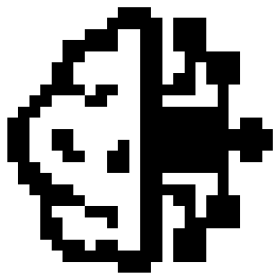

In [192]:
plt.imshow(object_numpy, cmap='gray')
plt.axis('off')
plt.savefig("test_obj.svg", format="svg")
plt.show()

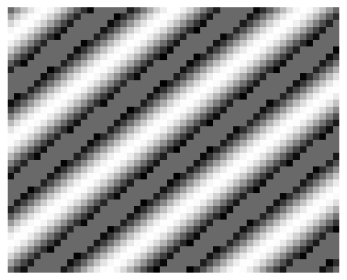

In [193]:
x = np.linspace(0, 5 * np.pi, W)
y = np.linspace(0, 5 * np.pi, H)
x_grid, y_grid = np.meshgrid(x, y)
ripples = np.sin(x_grid + y_grid)
ripples_normalized = (ripples - np.min(ripples)) / (np.max(ripples) - np.min(ripples))
ripples_normalized[ripples_normalized < 0.15] = 0.5

plt.imshow(ripples_normalized, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.savefig("test_background.svg", format="svg")
plt.show()

In [144]:
X = np.zeros((H, W, K))

for k in range(K):
    X[..., k] = ripples_normalized

np.random.seed(42)
x_positions = np.random.randint(0, W - w + 1, size=K)
y_positions = np.random.randint(0, H - h + 1, size=K)

for k, (x, y) in enumerate(zip(x_positions, y_positions)):
    X[y:(y+h), x:(x+w), k] = np.where(object_numpy < 1, object_numpy, X[y:(y+h), x:(x+w), k])

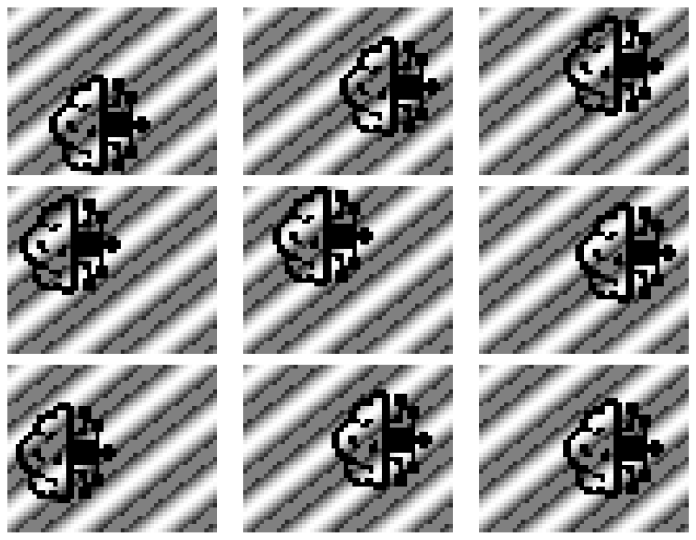

In [194]:
start_pos = np.random.randint(0, K)
selected_images = X[..., start_pos:start_pos + 9]

fig = plt.figure(figsize=(10, 8))
grid = GridSpec(3, 3, figure=fig)

for i in range(9):
    ax = fig.add_subplot(grid[i // 3, i % 3])
    ax.imshow(selected_images[..., i], cmap='gray')
    ax.axis('off')  # Убираем оси
    # ax.set_title(f"Изображение {i+1}", fontsize=10)

# fig.suptitle('Пример 9 изображений выборки', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("test_dataset.svg", format="svg")
plt.show()

In [146]:
F, B, s, A, elbo = run_EM(X, h, w, max_iter=500)

  3%|▎         | 14/500 [00:03<02:02,  3.97it/s]


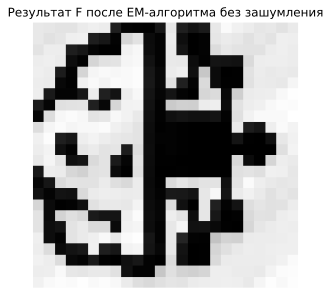

In [147]:
plt.imshow(F, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title("Результат F после EM-алгоритма без зашумления")
plt.show()

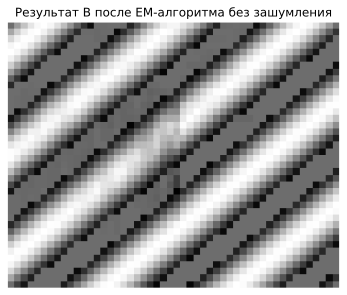

In [148]:
plt.imshow(B, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title("Результат B после EM-алгоритма без зашумления")
plt.show()

In [149]:
STD = 0.1

X_noised = X + np.random.normal(loc=0, scale=STD, size=(H, W, K))

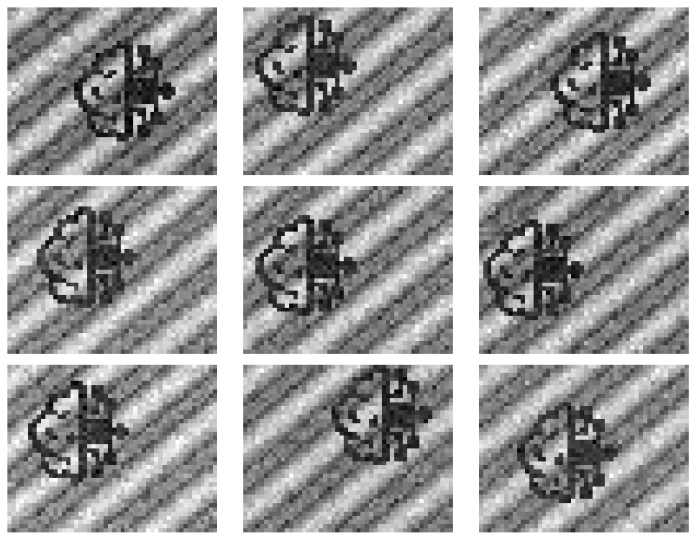

In [195]:
start_pos = np.random.randint(0, K - 9)
selected_images = X_noised[..., start_pos:start_pos + 9]

fig = plt.figure(figsize=(10, 8))
grid = GridSpec(3, 3, figure=fig)

for i in range(9):
    ax = fig.add_subplot(grid[i // 3, i % 3])
    ax.imshow(selected_images[..., i], cmap='gray')
    ax.axis('off')  # Убираем оси

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("test_background_noise.svg", format="svg")
plt.show()

In [151]:
# Для одного приближения

F_noised, B_noised, s_noised, A_noised, elbo_noised = run_EM(X_noised, h, w, max_iter=500)

  2%|▏         | 8/500 [00:02<02:06,  3.90it/s]


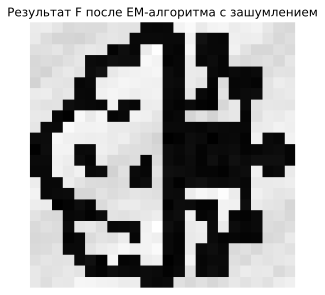

In [152]:
plt.imshow(F_noised, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title("Результат F после EM-алгоритма с зашумлением")
plt.show()

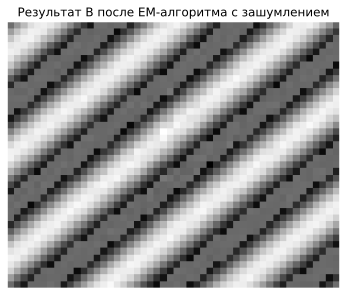

In [153]:
plt.imshow(B_noised, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title("Результат B после EM-алгоритма c зашумлением")
plt.show()

In [154]:
# Запуск с разным количеством итераций

iters = [1, 2, 3, 4, 5, 6, 50, 200, 800]
F_results = []
B_results = []

for it in iters:
    F_it, B_it, _, _, _ = run_EM(X_noised, h, w, max_iter=it)
    F_results.append(F_it)
    B_results.append(B_it)

  4%|▎         | 29/800 [00:07<03:26,  3.74it/s]


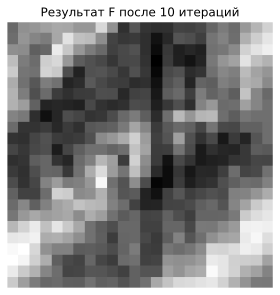

In [155]:
plt.imshow(F_results[0], cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title("Результат F после 10 итераций")
plt.show()

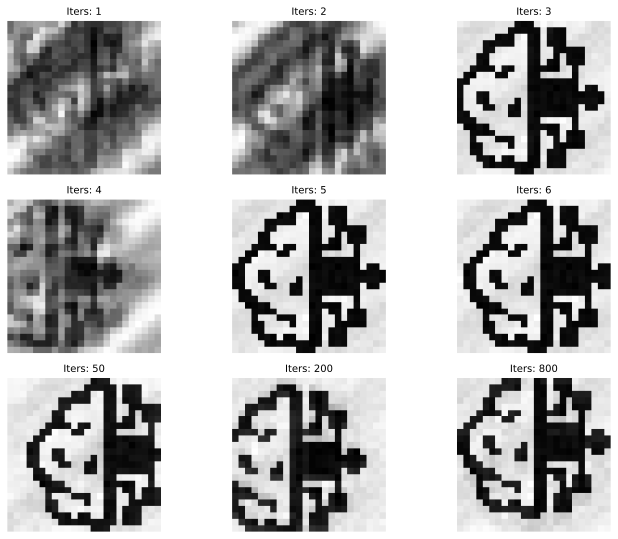

In [196]:
fig = plt.figure(figsize=(10, 8))
grid = GridSpec(3, 3, figure=fig)

for i in range(9):
    ax = fig.add_subplot(grid[i // 3, i % 3])
    ax.imshow(F_results[i], cmap='gray')
    ax.axis('off')  # Убираем оси
    ax.set_title(f"Iters: {iters[i]}", fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("result_exp1.svg", format="svg")
plt.show()

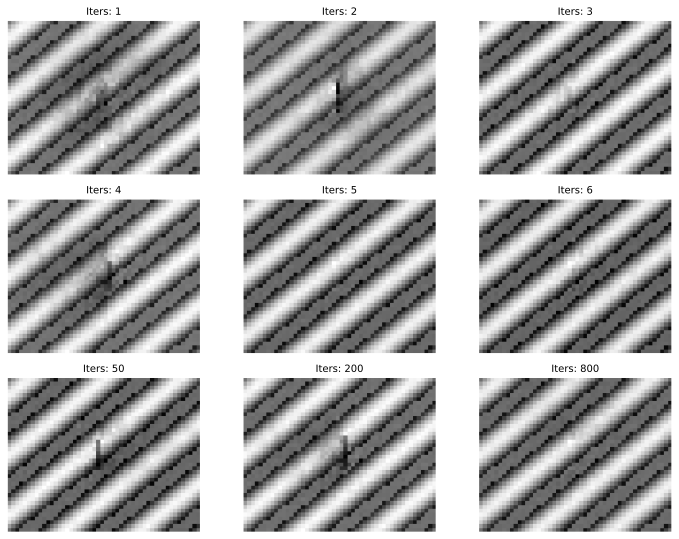

In [197]:
fig = plt.figure(figsize=(10, 8))
grid = GridSpec(3, 3, figure=fig)

for i in range(9):
    ax = fig.add_subplot(grid[i // 3, i % 3])
    ax.imshow(B_results[i], cmap='gray')
    ax.axis('off')  # Убираем оси
    ax.set_title(f"Iters: {iters[i]}", fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("result_exp1B.svg", format="svg")
plt.show()

In [158]:
F_restarts, B_restarts, _, _, elbo_restarts = run_EM_with_restarts(X_noised, h, w)

 18%|█▊        | 9/50 [00:06<00:28,  1.44it/s]


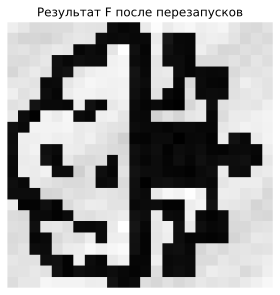

In [159]:
plt.imshow(F_restarts, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title("Результат F после перезапусков")
plt.show()

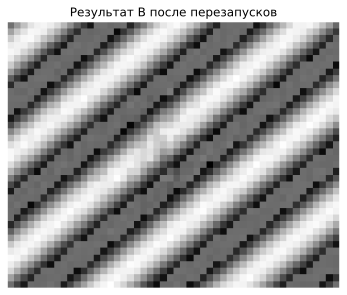

In [160]:
plt.imshow(B_restarts, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title("Результат B после перезапусков")
plt.show()

### Второй эксперимент - разные конфигурации данных

In [164]:
SIZE = 1000

X_SIZE = np.zeros((H, W, SIZE))

for size in range(SIZE):
    X_SIZE[..., size] = ripples_normalized

x_positions = np.random.randint(0, W - w + 1, size=SIZE)
y_positions = np.random.randint(0, H - h + 1, size=SIZE)

for size, (x, y) in enumerate(zip(x_positions, y_positions)):
    X_SIZE[y:(y+h), x:(x+w), size] = np.where(object_numpy < 1, object_numpy, X[y:(y+h), x:(x+w), k])

In [165]:
STDs = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]
SIZES = [50, 100, 200, 300, 500, 1000]

In [171]:
results_stds = dict()
for std in STDs:
    results_stds[std] = dict()

for std in STDs:
    X_NEW = X_SIZE + np.random.normal(loc=0.0, scale=std, size=(H, W, SIZE))
    for size in SIZES:
        F_res, B_res, _, _, elbo_res = run_EM(X_NEW[..., :size], h, w, use_good_init=True)
        elbo_res = np.array(elbo_res) / size
        elbo_res = elbo_res.tolist()
        results_stds[std][size] = [F_res, B_res, elbo_res]

100%|██████████| 50/50 [02:49<00:00,  3.39s/it]


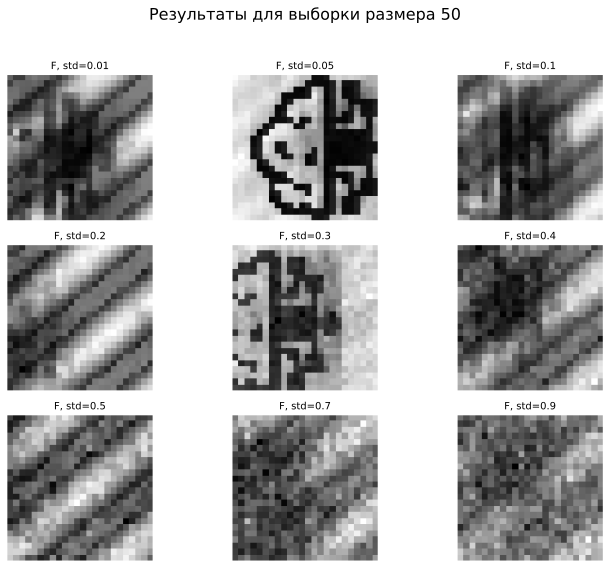

In [172]:
data_size = SIZES[0]

fig = plt.figure(figsize=(10, 8))
grid = GridSpec(3, 3, figure=fig)

for i, std in enumerate(STDs):
    ax = fig.add_subplot(grid[i // 3, i % 3])
    ax.imshow(results_stds[std][data_size][0], cmap='gray')
    ax.axis('off')  # Убираем оси
    ax.set_title(f"F, std={std}", fontsize=10)

fig.suptitle(f'Результаты для выборки размера {50}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

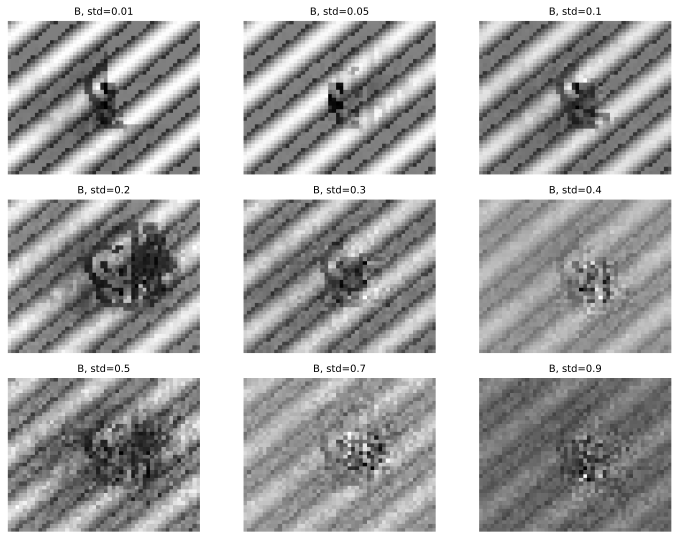

In [198]:
data_size = SIZES[0]

fig = plt.figure(figsize=(10, 8))
grid = GridSpec(3, 3, figure=fig)

for i, std in enumerate(STDs):
    ax = fig.add_subplot(grid[i // 3, i % 3])
    ax.imshow(results_stds[std][data_size][1], cmap='gray')
    ax.axis('off')  # Убираем оси
    ax.set_title(f"B, std={std}", fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("result_exp2B.svg", format="svg")
plt.show()

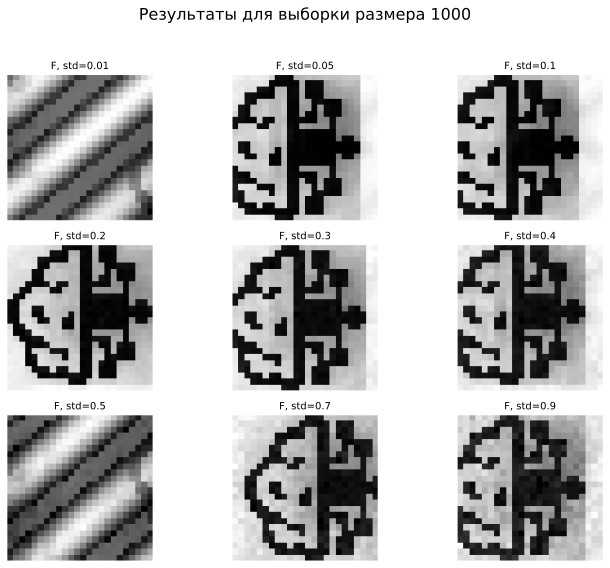

In [175]:
data_size = SIZES[5]

fig = plt.figure(figsize=(10, 8))
grid = GridSpec(3, 3, figure=fig)

for i, std in enumerate(STDs):
    ax = fig.add_subplot(grid[i // 3, i % 3])
    ax.imshow(results_stds[std][data_size][0], cmap='gray')
    ax.axis('off')  # Убираем оси
    ax.set_title(f"F, std={std}", fontsize=10)

fig.suptitle(f'Результаты для выборки размера {data_size}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

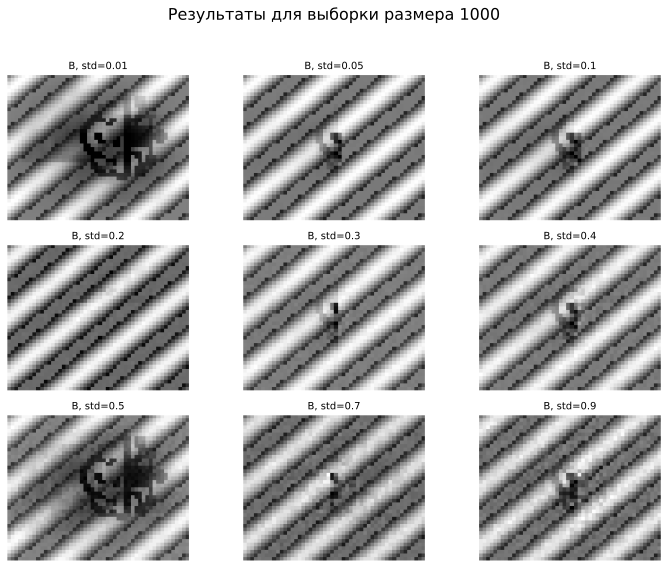

In [176]:
data_size = SIZES[5]

fig = plt.figure(figsize=(10, 8))
grid = GridSpec(3, 3, figure=fig)

for i, std in enumerate(STDs):
    ax = fig.add_subplot(grid[i // 3, i % 3])
    ax.imshow(results_stds[std][data_size][1], cmap='gray')
    ax.axis('off')  # Убираем оси
    ax.set_title(f"B, std={std}", fontsize=10)

fig.suptitle(f'Результаты для выборки размера {data_size}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

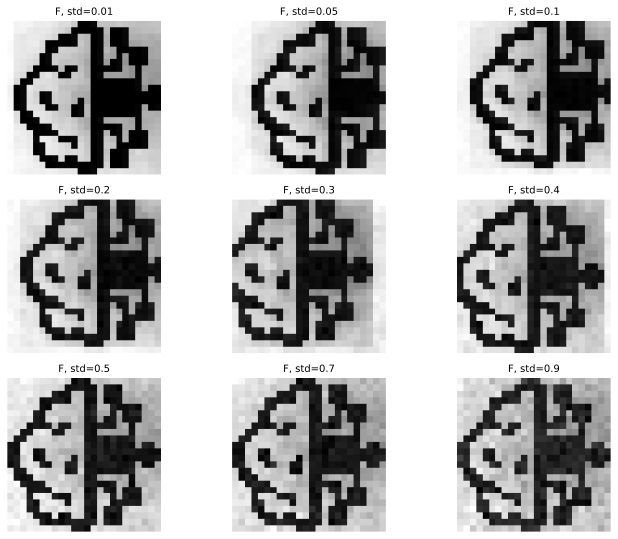

In [201]:
data_size = SIZES[4]

fig = plt.figure(figsize=(10, 8))
grid = GridSpec(3, 3, figure=fig)

for i, std in enumerate(STDs):
    ax = fig.add_subplot(grid[i // 3, i % 3])
    ax.imshow(results_stds[std][data_size][0], cmap='gray')
    ax.axis('off')  # Убираем оси
    ax.set_title(f"F, std={std}", fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("exp2_stds_F500.svg", format='svg')
plt.show()

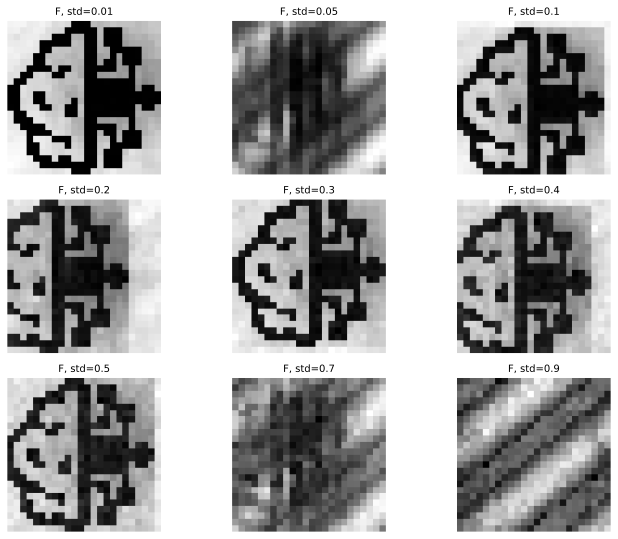

In [200]:
data_size = SIZES[3]

fig = plt.figure(figsize=(10, 8))
grid = GridSpec(3, 3, figure=fig)

for i, std in enumerate(STDs):
    ax = fig.add_subplot(grid[i // 3, i % 3])
    ax.imshow(results_stds[std][data_size][0], cmap='gray')
    ax.axis('off')  # Убираем оси
    ax.set_title(f"F, std={std}", fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("exp2_stds_F300_more.svg", format='svg')
plt.show()

In [179]:
new_results_stds = dict()
for std in [0.4, 1.0, 1.5, 2.0]:
    new_results_stds[std] = dict()

for std in [0.4, 1.0, 1.5, 2.0]:
    X_NEW = np.clip(X_SIZE + np.random.normal(loc=0.0, scale=std, size=(H, W, SIZE)), 0, 1)
    for size in [50, 100, 200, 300]:
        F_res, B_res, _, _, elbo_res = run_EM(X_NEW[..., :size], h, w)
        elbo_res = np.array(elbo_res) / size
        elbo_res = elbo_res.tolist()
        new_results_stds[std][size] = [F_res, B_res, elbo_res]

100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


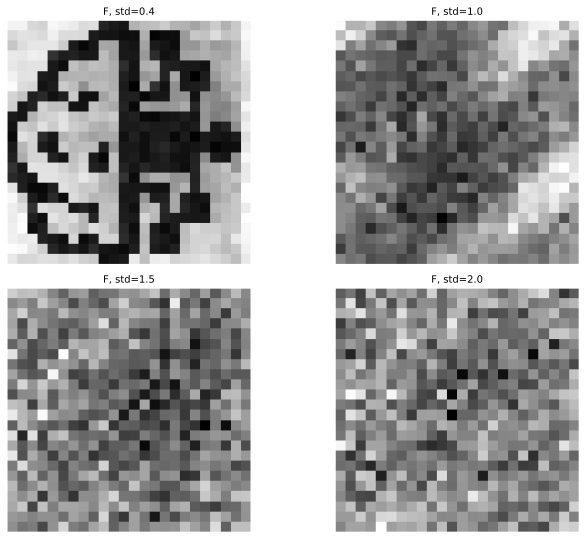

In [199]:
new_sizes = [50, 100, 200, 300]
data_size = new_sizes[2]

fig = plt.figure(figsize=(10, 8))
grid = GridSpec(2, 2, figure=fig)

for i, std in enumerate([0.4, 1.0, 1.5, 2.0]):
    ax = fig.add_subplot(grid[i // 2, i % 2])
    ax.imshow(new_results_stds[std][data_size][0], cmap='gray')
    ax.axis('off')  # Убираем оси
    ax.set_title(f"F, std={std}", fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("exp2_stds_F.svg", format='svg')
plt.show()

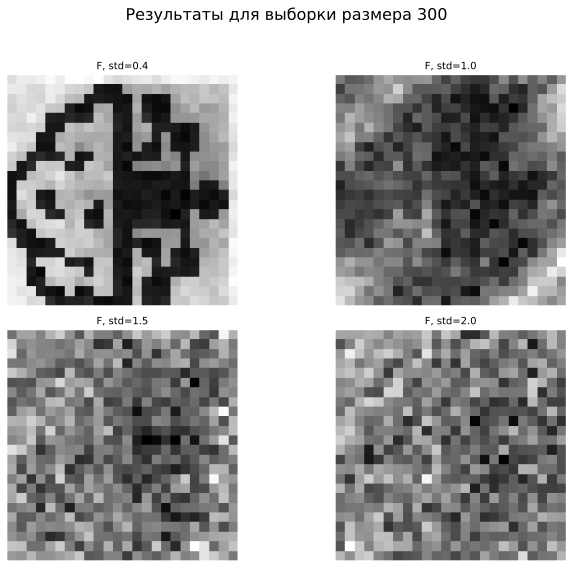

In [182]:
new_sizes = [50, 100, 200, 300]
data_size = new_sizes[3]

fig = plt.figure(figsize=(10, 8))
grid = GridSpec(2, 2, figure=fig)

for i, std in enumerate([0.4, 1.0, 1.5, 2.0]):
    ax = fig.add_subplot(grid[i // 2, i % 2])
    ax.imshow(new_results_stds[std][data_size][0], cmap='gray')
    ax.axis('off')  # Убираем оси
    ax.set_title(f"F, std={std}", fontsize=10)

fig.suptitle(f'Результаты для выборки размера {data_size}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [183]:
again_results_stds = dict()
for std in [0.6, 0.7, 0.8, 0.9, 1.0]:
    again_results_stds[std] = dict()

for std in [0.6, 0.7, 0.8, 0.9, 1.0]:
    X_NEW = np.clip(X_SIZE + np.random.normal(loc=0.0, scale=std, size=(H, W, SIZE)), 0, 1)
    for size in [300]:
        F_res, B_res, _, _, elbo_res = run_EM(X_NEW[..., :size], h, w)
        elbo_res = np.array(elbo_res) / size
        elbo_res = elbo_res.tolist()
        again_results_stds[std][size] = [F_res, B_res, elbo_res]

100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


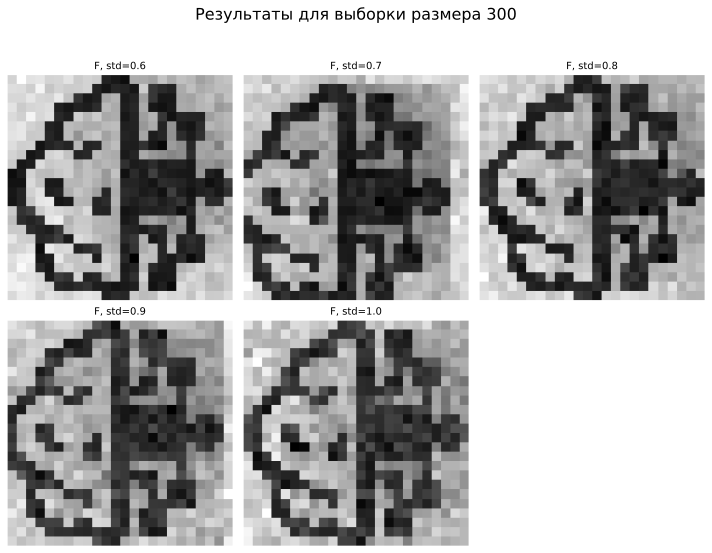

In [184]:
data_size = 300

fig = plt.figure(figsize=(10, 8))
grid = GridSpec(2, 3, figure=fig)

for i, std in enumerate([0.6, 0.7, 0.8, 0.9, 1.0]):
    ax = fig.add_subplot(grid[i // 3, i % 3])
    ax.imshow(again_results_stds[std][data_size][0], cmap='gray')
    ax.axis('off')  # Убираем оси
    ax.set_title(f"F, std={std}", fontsize=10)

fig.suptitle(f'Результаты для выборки размера {data_size}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

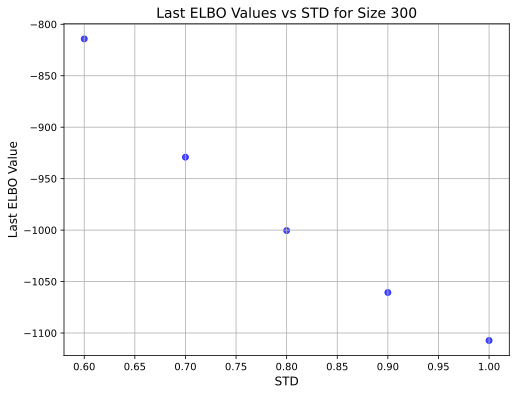

In [202]:
# Переберём значения STD и соберём последние элементы списков elbo для ключа 300
std_values = []
elbo_values = []

for std, sizes_dict in again_results_stds.items():
    if 300 in sizes_dict:
        last_elbo = sizes_dict[300][2][-1]
        std_values.append(std)
        elbo_values.append(last_elbo)

# Построение scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(std_values, elbo_values, c='blue', alpha=0.7)
plt.title("Last ELBO Values vs STD for Size 300", fontsize=14)
plt.xlabel("STD", fontsize=12)
plt.ylabel("Last ELBO Value", fontsize=12)
plt.grid(True)
plt.savefig("exp2_elbo_values.svg", format="svg")
plt.show()

In [186]:
more_results_stds = dict()
for std in [1.2, 1.5, 1.7, 1.9]:
    more_results_stds[std] = dict()

for std in [1.2, 1.5, 1.7, 1.9]:
    X_NEW = np.clip(X_SIZE + np.random.normal(loc=0.0, scale=std, size=(H, W, SIZE)), 0, 1)
    for size in [300]:
        F_res, B_res, _, _, elbo_res = run_EM(X_NEW[..., :size], h, w)
        elbo_res = np.array(elbo_res) / size
        elbo_res = elbo_res.tolist()
        more_results_stds[std][size] = [F_res, B_res, elbo_res]

100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


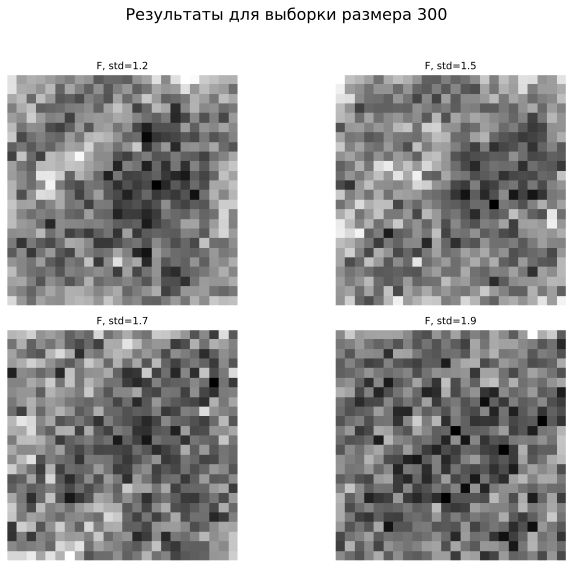

In [187]:
data_size = 300

fig = plt.figure(figsize=(10, 8))
grid = GridSpec(2, 2, figure=fig)

for i, std in enumerate([1.2, 1.5, 1.7, 1.9]):
    ax = fig.add_subplot(grid[i // 2, i % 2])
    ax.imshow(more_results_stds[std][data_size][0], cmap='gray')
    ax.axis('off')  # Убираем оси
    ax.set_title(f"F, std={std}", fontsize=10)

fig.suptitle(f'Результаты для выборки размера {data_size}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

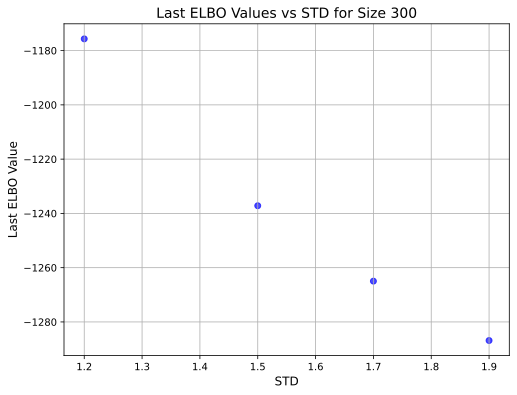

In [188]:
# Переберём значения STD и соберём последние элементы списков elbo для ключа 300
std_values = []
elbo_values = []

for std, sizes_dict in more_results_stds.items():
    if 300 in sizes_dict:
        last_elbo = sizes_dict[300][2][-1]
        std_values.append(std)
        elbo_values.append(last_elbo)


# Построение scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(std_values, elbo_values, c='blue', alpha=0.7)
plt.title("Last ELBO Values vs STD for Size 300", fontsize=14)
plt.xlabel("STD", fontsize=12)
plt.ylabel("Last ELBO Value", fontsize=12)
plt.grid(True)
plt.show()

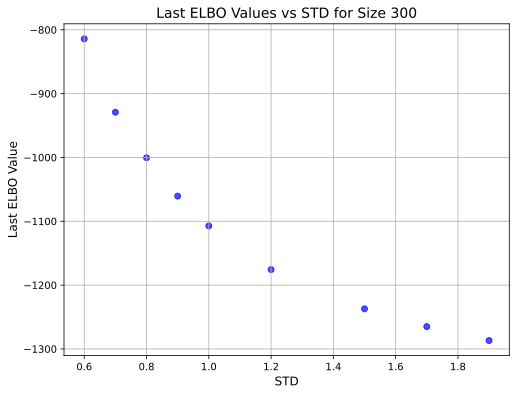

In [189]:
std_values = []
elbo_values = []

for std, sizes_dict in more_results_stds.items():
    if 300 in sizes_dict:
        last_elbo = sizes_dict[300][2][-1]
        std_values.append(std)
        elbo_values.append(last_elbo)

for std, sizes_dict in again_results_stds.items():
    if 300 in sizes_dict:
        last_elbo = sizes_dict[300][2][-1]
        std_values.append(std)
        elbo_values.append(last_elbo)

# Построение scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(std_values, elbo_values, c='blue', alpha=0.7)
plt.title("Last ELBO Values vs STD for Size 300", fontsize=14)
plt.xlabel("STD", fontsize=12)
plt.ylabel("Last ELBO Value", fontsize=12)
plt.grid(True)
plt.show()

### Эксперимент 3

In [217]:
X_3 = np.clip(X_SIZE + np.random.normal(loc=0.0, scale=0.3, size=(H, W, SIZE)), 0, 1)
data_size = 500

F_exp3, B_exp3, _, _, elbo_exp3 = run_EM(X_3, h, w, use_MAP=False)
# F_exp3_map, B_exp3_map, _, _, elbo_exp3_map = run_EM(X_3, h, w, use_MAP=True, use_good_init=True)

 34%|███▍      | 17/50 [00:55<01:47,  3.25s/it]


In [ ]:
F_exp3_map, B_exp3_map, _, _, elbo_exp3_map = run_EM(X_3, h, w, use_MAP=True)

 62%|██████▏   | 31/50 [01:38<00:59,  3.15s/it]

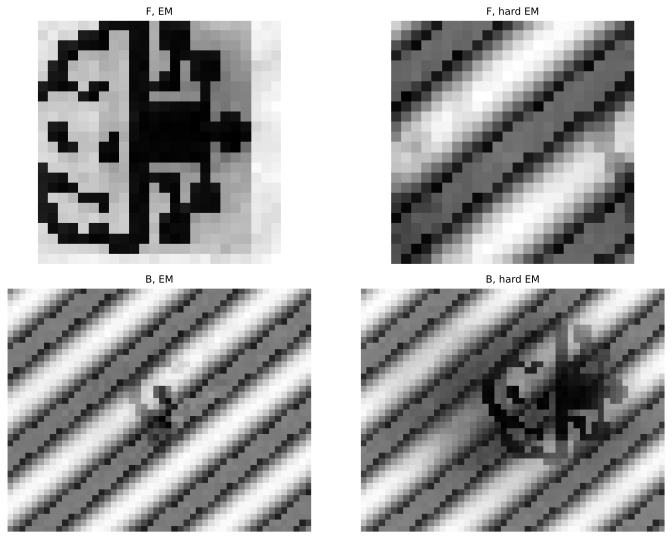

In [222]:
fig = plt.figure(figsize=(10, 8))
grid = GridSpec(2, 2, figure=fig)

images = [F_exp3, F_exp3_map, B_exp3, B_exp3_map]
names = ["F, EM", "F, hard EM", "B, EM", "B, hard EM"]

for i in range(4):
    ax = fig.add_subplot(grid[i // 2, i % 2])
    ax.imshow(images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(names[i], fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("exp3.svg", format="svg")
plt.show()

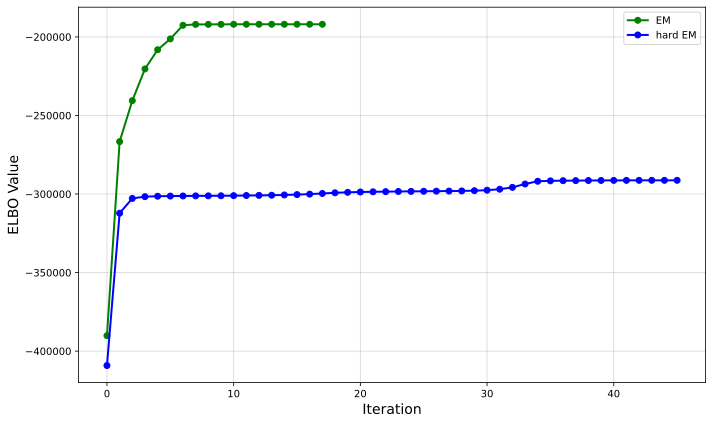

In [220]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(elbo_exp3)), elbo_exp3, marker='o', color="green", linestyle='-', linewidth=2, markersize=6, label="EM")
plt.plot(np.arange(len(elbo_exp3_map)), elbo_exp3_map, marker='o', color="blue", linestyle='-', linewidth=2, markersize=6, label="hard EM")
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('ELBO Value', fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.legend()

plt.savefig("exp3_elbo.svg", format="svg")
plt.show()

### Эксперимент 4. Применяем к реальным данным

In [37]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1sehiJtQDyl8UbZ2zsguYx28Xi-FGs8qd' -O cmc_data_1000.npy

--2024-12-04 16:24:19--  https://docs.google.com/uc?export=download&id=1sehiJtQDyl8UbZ2zsguYx28Xi-FGs8qd
Resolving docs.google.com (docs.google.com)... 209.85.200.138, 209.85.200.101, 209.85.200.102, ...
Connecting to docs.google.com (docs.google.com)|209.85.200.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1sehiJtQDyl8UbZ2zsguYx28Xi-FGs8qd&export=download [following]
--2024-12-04 16:24:19--  https://drive.usercontent.google.com/download?id=1sehiJtQDyl8UbZ2zsguYx28Xi-FGs8qd&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|209.85.200.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25725128 (25M) [application/octet-stream]
Saving to: ‘cmc_data_1000.npy’

cmc_data_1000.npy   100%[===================>]  24.53M  87.7MB/s  

In [ ]:
original_data = np.load("cmc_data_1000.npy")

In [2]:
original_data = np.load("cmc_data_1000.npy")

In [3]:
print(original_data.shape)

(105, 245, 1000)


In [12]:
all_fones = []
all_faces = []

In [13]:
original_data = np.load("data_cmc_50.npy")
mean = original_data.mean()
std = original_data.std()

mainF, mainB, mainS, mainA, main_elbos = run_EM(X=(original_data - mean)/std, h=86, w=64, max_iter=20)

all_fones.append(np.clip(mainB*std + mean, 0, 255).astype(np.uint8))
all_faces.append(np.clip(mainF*std + mean, 0, 255).astype(np.uint8))

iter: 0 / 20
iter: 1 / 20


In [15]:
original_data = np.load("cmc_data_100.npy")
mean = original_data.mean()
std = original_data.std()

mainF, mainB, mainS, mainA, main_elbos = run_EM(X=(original_data - mean)/std, h=86, w=64, max_iter=20)

all_fones.append(np.clip(mainB*std + mean, 0, 255).astype(np.uint8))
all_faces.append(np.clip(mainF*std + mean, 0, 255).astype(np.uint8))

iter: 0 / 20
iter: 1 / 20


In [16]:
original_data = np.load("cmc_data_300.npy")
mean = original_data.mean()
std = original_data.std()

mainF, mainB, mainS, mainA, main_elbos = run_EM(X=(original_data - mean)/std, h=86, w=64, max_iter=20)

all_fones.append(np.clip(mainB*std + mean, 0, 255).astype(np.uint8))
all_faces.append(np.clip(mainF*std + mean, 0, 255).astype(np.uint8))

iter: 0 / 20
iter: 1 / 20
iter: 2 / 20
iter: 3 / 20
iter: 4 / 20
iter: 5 / 20
iter: 6 / 20
iter: 7 / 20
iter: 8 / 20
iter: 9 / 20
iter: 10 / 20
iter: 11 / 20
iter: 12 / 20
iter: 13 / 20
iter: 14 / 20
iter: 15 / 20
iter: 16 / 20
iter: 17 / 20
iter: 18 / 20
iter: 19 / 20


In [17]:
original_data = np.load("cmc_data_500.npy")
mean = original_data.mean()
std = original_data.std()

mainF, mainB, mainS, mainA, main_elbos = run_EM(X=(original_data - mean)/std, h=86, w=64, max_iter=20)

all_fones.append(np.clip(mainB*std + mean, 0, 255).astype(np.uint8))
all_faces.append(np.clip(mainF*std + mean, 0, 255).astype(np.uint8))

iter: 0 / 20
iter: 1 / 20
iter: 2 / 20
iter: 3 / 20
iter: 4 / 20
iter: 5 / 20
iter: 6 / 20
iter: 7 / 20
iter: 8 / 20
iter: 9 / 20
iter: 10 / 20
iter: 11 / 20
iter: 12 / 20
iter: 13 / 20
iter: 14 / 20
iter: 15 / 20
iter: 16 / 20
iter: 17 / 20
iter: 18 / 20
iter: 19 / 20


In [22]:
original_data = np.load("cmc_data_1000.npy")
mean = original_data.mean()
std = original_data.std()

mainF, mainB, mainS, mainA, main_elbos = run_EM(X=(original_data - mean)/std, h=86, w=64, max_iter=20)

all_fones.append(np.clip(mainB*std + mean, 0, 255).astype(np.uint8))
all_faces.append(np.clip(mainF*std + mean, 0, 255).astype(np.uint8))

iter: 0 / 20
iter: 1 / 20
iter: 2 / 20
iter: 3 / 20
iter: 4 / 20
iter: 5 / 20
iter: 6 / 20
iter: 7 / 20
iter: 8 / 20
iter: 9 / 20
iter: 10 / 20
iter: 11 / 20
iter: 12 / 20
iter: 13 / 20
iter: 14 / 20
iter: 15 / 20
iter: 16 / 20
iter: 17 / 20
iter: 18 / 20
iter: 19 / 20


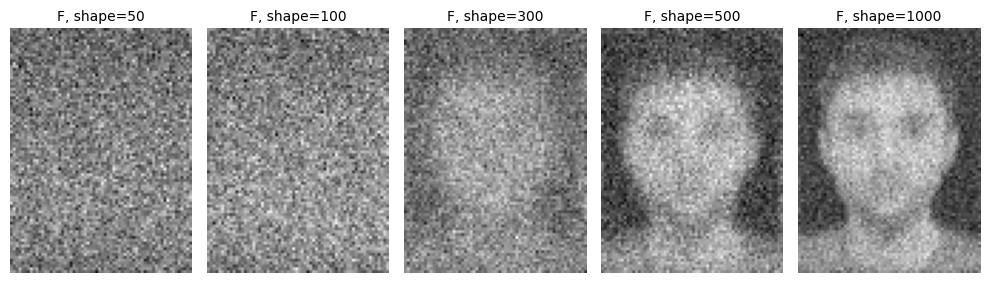

In [23]:
# DATA
shapes = [50, 100, 300, 500, 1000]
 
fig = plt.figure(figsize=(10, 8)) 
grid = GridSpec(1, 5, figure=fig) 
 
for i, data in enumerate(all_faces): 
    ax = fig.add_subplot(grid[i // 5, i % 5]) 
    ax.imshow(data, cmap='gray') 
    ax.axis('off')  # Убираем оси 
    ax.set_title(f"F, shape={shapes[i]}", fontsize=10) 
 
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("exp4_some_faces.svg", format="svg")
 
plt.show()

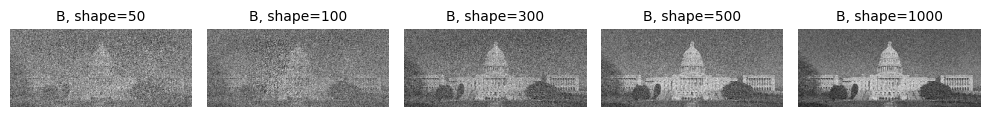

In [25]:
# DATA
shapes = [50, 100, 300, 500, 1000]
 
fig = plt.figure(figsize=(10, 8)) 
grid = GridSpec(1, 5, figure=fig) 
 
for i, data in enumerate(all_fones): 
    ax = fig.add_subplot(grid[i // 5, i % 5]) 
    ax.imshow(data, cmap='gray') 
    ax.axis('off')  # Убираем оси 
    ax.set_title(f"B, shape={shapes[i]}", fontsize=10) 
 
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("exp4_some_backs.svg", format="svg")
 
plt.show()

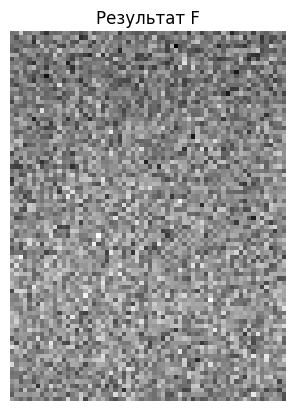

In [9]:
plt.imshow(all_faces[0], cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title("Результат F")
plt.show()

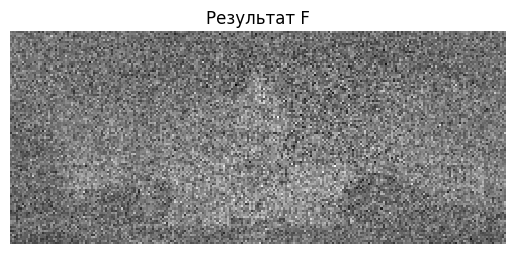

In [11]:
plt.imshow(all_fones[0], cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title("Результат F")
plt.show()

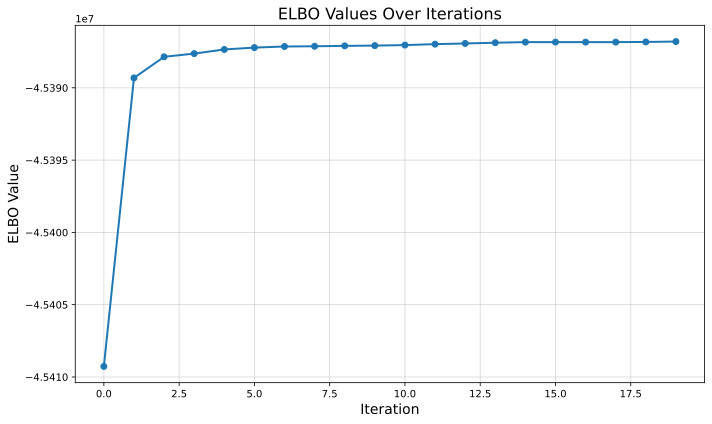

In [76]:
# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(main_elbos)), main_elbos, marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('ELBO Values Over Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('ELBO Value', fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [77]:
mainF, mainB, mainS, mainA, main_elbos = run_EM(X=original_data, h=86, w=64, max_iter=20)

 95%|█████████▌| 19/20 [12:19<00:38, 38.94s/it]


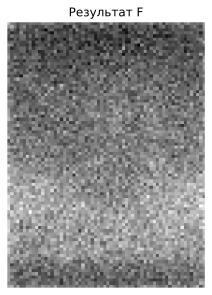

In [78]:
plt.imshow(mainF, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title("Результат F")
plt.show()

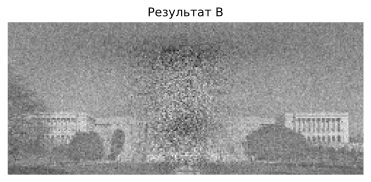

In [79]:
plt.imshow(mainB, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title("Результат B")
plt.show()

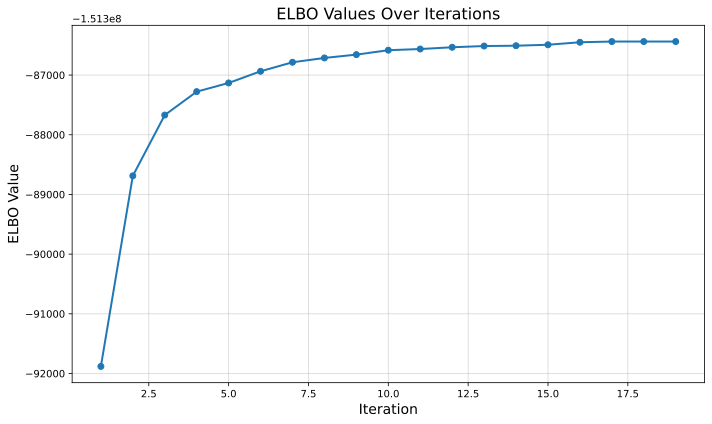

In [84]:
# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(main_elbos)), main_elbos[1:], marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('ELBO Values Over Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('ELBO Value', fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()